In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


In [3]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset
import torch
from tqdm import tqdm


Vediamo alcuni metodi che sono utilizzati per calcolare e valutare la qualità di un modello generativo!


# Perplexity

Una tecnica molto utilizzata (se non la più utilizzata) per valutare a priori la qualità di un modello generativo è la perplexity. Ricordati la formula per calcolare la perplexity:

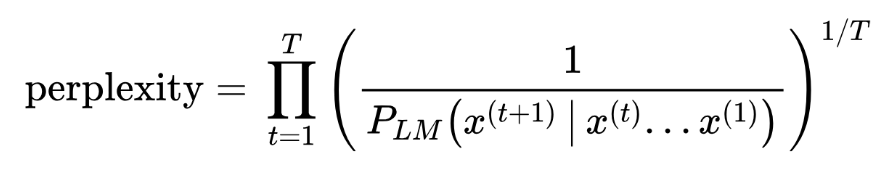

Vediamo ora come calcolare la perplexity di un modello generativo, per esempio GPT-2

Carichiamo il modello, in questo caso carichiamo il modello gpt2-large

In [6]:
device = "cuda"
model_id_large = "gpt2-large"
tokenizer = GPT2TokenizerFast.from_pretrained(model_id_large)

model_large = GPT2LMHeadModel.from_pretrained(model_id_large).to(device)


In [10]:
model_id_small = "gpt2"
model_small = GPT2LMHeadModel.from_pretrained(model_id_small).to(device)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Carichiamo adesso il dataset che rappresenta il nostro corpus e su cui andremo a calcolare le probabilità condizionate di generazione del token t+1 partendo dalla sequenza di token 1...t

In [11]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

Tokenizziamo il nostro corpus di testo sul quale andremo a calcolare la perplexity

In [12]:
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors


Siccome il modello ha una lunghezza predefinita, per calcolare correttamente la perplexity dobbiamo tenere in considerazione questa lunghezza di input e per farlo, dobbiamo considerare una "sliding window" che ci definisce il contesto esatto per calcolare la parola generata.

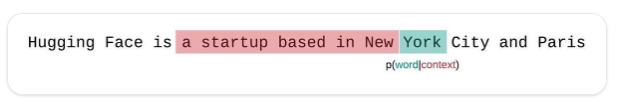

Ma per farlo in maniera efficiente ed evitare un passaggio attraverso i pesi del modello, è buona norma e prassi utilizzare un valore di "stride", muovendo il contesto per questo valore di stride invece di muoverlo 1 token alla volta.

Per calcolare invece la probabilità di generazione di un token, utilizzando la libreria HuggingFace Transformers basta passare come label del modello gli stessi input_ids delle parole che vogliamo generare.

In [16]:
max_length = model_large.config.n_positions
stride = 512
seq_len = encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model_large(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())


100%|█████████▉| 560/562 [05:04<00:01,  1.84it/s]


In [17]:
print(f"Perplexity Large GPT2 Model: {ppl}")

Perplexity Large GPT2 Model: 16.45410919189453


In [14]:
max_length = model_small.config.n_positions
stride = 512
seq_len = encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model_small(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())


100%|█████████▉| 560/562 [00:57<00:00,  9.70it/s]


In [15]:
print(f"Perplexity Small GPT2 Model: {ppl}")

Perplexity Small GPT2 Model: 25.1879940032959
